In [66]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

np.set_printoptions(precision=3, suppress=True)

In [67]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential

In [68]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']
df = pd.read_csv('auto-mpg.data', names= column_names , na_values='?', comment='\t',sep=' ',skipinitialspace=True)


In [69]:
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [70]:
#clean data set
df = df.dropna()

# convert categorical 'Origin' data into one-hot data
origin = df.pop('Origin')
df['USA'] = (origin ==  1)*1
df['Europe'] = (origin == 2)*1
df['Japan'] = (origin == 3)*1

In [71]:
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [72]:
#split data into train and test
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

print(df.shape , train_df.shape , test_df.shape)

(392, 10) (314, 10) (78, 10)


In [73]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [74]:
#split features form labels
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [75]:
# custom plot function
def plot(feature , x=None , y=None):
    plt.figure(figsize=(10,8))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if x is not None and y is not None:
        plt.plot(x,y, color='k' , label='Prediction')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

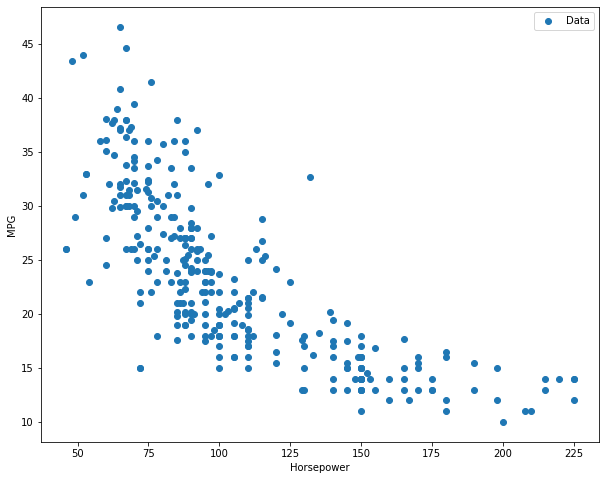

In [76]:
plot('Horsepower')

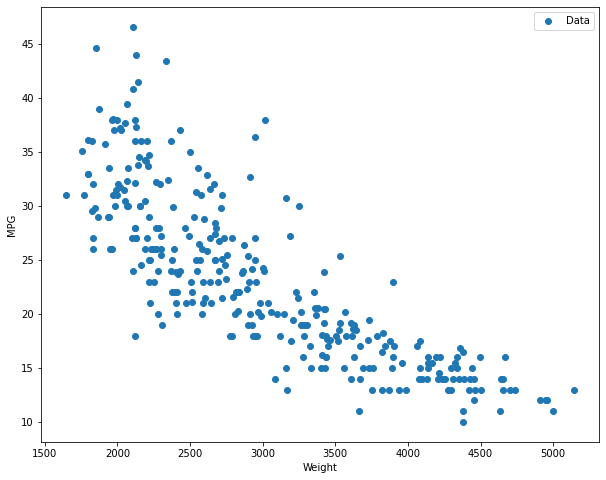

In [77]:
plot('Weight')

In [78]:
# Normalize
print(train_df.describe().transpose()[['mean', 'std']])

# Normalization
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
     0.197]]


In [79]:
# When the layer is called it returns the input data, with each feature independently normalized:
# (input-mean)/stddev
first = np.array(train_features[:1])
print('First example:', first)
print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [80]:
#Regression
# 1. Normalise the input horse power
# 2. Apply a linear tranformation (y = m*x+b) to produce a output using layers.Dense

feature = 'Horsepower'

single_feature = np.array(train_features[feature]).reshape(-1,1)
print(single_feature.shape, train_features.shape)

# Normalization
single_feature_normalizer = preprocessing.Normalization()

# adapt to the data
single_feature_normalizer.adapt(single_feature)

(314, 1) (314, 9)


In [81]:
single_feature.shape

(314, 1)

In [82]:
# sequential model for single feature
single_feature_model = tf.keras.models.Sequential()
single_feature_model.add(tf.keras.Input(shape=(1)))
single_feature_model.add(single_feature_normalizer)
single_feature_model.add(tf.keras.layers.Dense(1))

single_feature_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_16 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [83]:
#loss and optimiser
loss = keras.losses.MeanAbsoluteError()
optimiser = keras.optimizers.Adam(lr=0.1)


c:\Users\S.Viknesh\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [84]:
#complie the model
single_feature_model.compile(optimizer=optimiser , loss= loss  )

In [85]:
Result = single_feature_model.fit(train_features[feature],train_labels,
    epochs=100,
    verbose = 1,
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 0s 13ms/step - loss: 22.8700 - val_loss: 22.9319
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.0677 - val_loss: 22.1322
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 21.2623 - val_loss: 21.3319
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 20.4633 - val_loss: 20.5318
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 19.6648 - val_loss: 19.7317
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 18.8620 - val_loss: 18.9319
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 18.0646 - val_loss: 18.1321
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 17.2635 - val_loss: 17.3320
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 16.4624 - val_loss: 16.5320
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 15.6625 - val_loss: 15.7320
Epoch 11

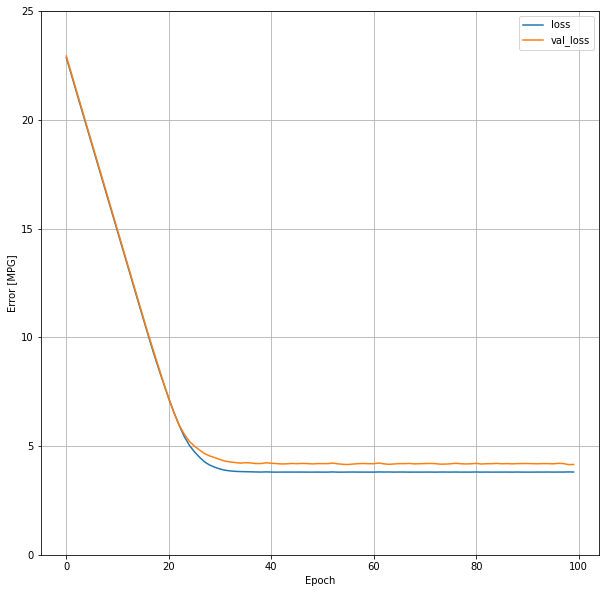

In [86]:
def plot_loss(Result):
    plt.figure(figsize=(10,10))
    plt.plot(Result.history['loss'], label='loss')
    plt.plot(Result.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(Result)

In [87]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels , verbose = 1
)

3/3 [==============================] - 0s 1ms/step - loss: 3.6527


3.652677059173584

7/7 [==============================] - 0s 997us/step


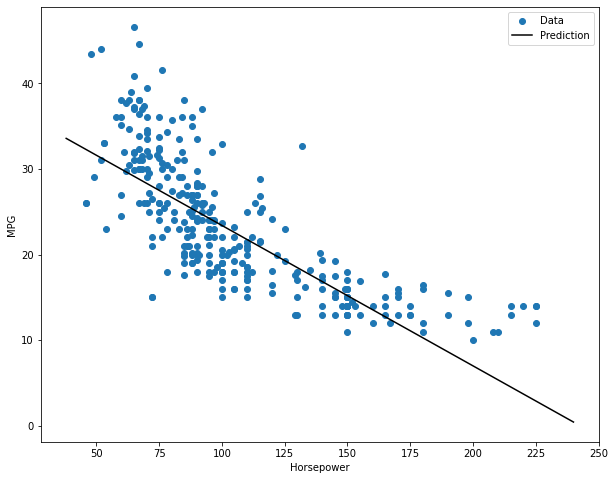

In [88]:
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = np.linspace(range_min,range_max , 200)
y = single_feature_model.predict(x)

plot(feature , x,y)

now a DNN

In [89]:
#DNN
dnn_model = tf.keras.models.Sequential()
dnn_model.add(tf.keras.Input(shape=(1)))
dnn_model.add(single_feature_normalizer)
dnn_model.add(tf.keras.layers.Dense(64 , activation = 'relu'))
dnn_model.add(tf.keras.layers.Dense(64, activation = 'relu'))
dnn_model.add(tf.keras.layers.Dense(1))

In [90]:
dnn_model.compile( loss = loss , optimizer = tf.keras.optimizers.Adam(0.001))
dnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_17 (Dense)            (None, 64)                128       
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [91]:
dnn_model.fit(
    train_features[feature] , train_labels,
    validation_split = 0.2,
    verbose = 1 , epochs = 100
)

Epoch 1/100
8/8 [==============================] - 0s 14ms/step - loss: 23.0295 - val_loss: 23.3876
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.7727 - val_loss: 23.1151
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 22.5053 - val_loss: 22.8008
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 22.1822 - val_loss: 22.4241
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 21.7883 - val_loss: 21.9579
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 21.3014 - val_loss: 21.3630
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 20.6622 - val_loss: 20.6165
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 19.8594 - val_loss: 19.7176
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 18.9550 - val_loss: 18.6941
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 17.9918 - val_loss: 17.6677
Epoch 11

In [92]:
dnn_model.evaluate(test_features[feature] , test_labels , verbose= 1)

3/3 [==============================] - 0s 1ms/step - loss: 2.9507


2.950718879699707

7/7 [==============================] - 0s 830us/step


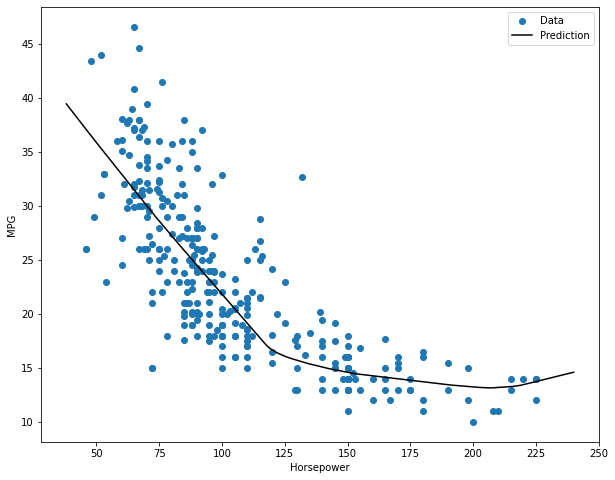

In [93]:
 x = np.linspace(range_min , range_max , 200)
 y = dnn_model.predict(x)

 plot(feature , x, y)

In [97]:
# multiple inputs
l_model = tf.keras.models.Sequential()
l_model.add(normalizer)
l_model.add(layers.Dense(units = 1))

l_model.compile( optimizer= tf.optimizers.Adam(learning_rate=0.1) , loss= loss )


In [98]:
l_model.fit(
    train_features ,train_labels , epochs =100 , verbose =1 , validation_split =0.2
)

Epoch 1/100
8/8 [==============================] - 0s 14ms/step - loss: 22.8665 - val_loss: 23.1613
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 22.0247 - val_loss: 22.4448
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 21.2003 - val_loss: 21.7180
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 20.3921 - val_loss: 20.9916
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 19.5509 - val_loss: 20.2435
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 18.7472 - val_loss: 19.5078
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 17.9165 - val_loss: 18.7650
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 17.1191 - val_loss: 18.0528
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 16.3015 - val_loss: 17.3342
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 15.5210 - val_loss: 16.6411
Epoch 11

In [99]:
l_model.evaluate( test_features ,test_labels ,verbose =1 )

3/3 [==============================] - 0s 999us/step - loss: 2.4793


2.4792943000793457